# Pengerjaan Tugas Deep Learning menggunakan TensorFlow (Week 7, Dataset IMDb)

File ini memuat pelatihan model Bidirectional RNN dan Deep RNN, masing-masing menggunakan TensorFlow, untuk dataset IMDb yang tersedia di module

# Persiapan: Instalasi library dan Data Preprocessing

### 1. Memastikan Instalasi library

In [1]:
# !pip install numpy matplotlib scikit-learn torch tensorflow
# %pip install numpy matplotlib scikit-learn torch tensorflow[and-cuda] keras-tuner nltk imbalanced-learn

%pip install keras-tuner imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


### 2. Mengimpor Library yang Dibutuhkan

In [2]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import json
import re
import string
import time
from copy import deepcopy

# Memeriksa apakah GPU tersedia dan dapat digunakan oleh TensorFlow
gpu_available = tf.test.is_gpu_available()
print(f"GPU available: {gpu_available}")


2025-04-25 23:08:51.034753: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 23:08:51.101323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745597331.130852  265400 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745597331.137711  265400 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745597331.176037  265400 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: True


I0000 00:00:1745597335.012574  265400 gpu_device.cc:2019] Created device /device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


### 3. Mendefinisikan Parameter dan Pre-processing Dataset

In [3]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 300
BATCH_SIZE = 16
EPOCHS = 25

print("Memuat dataset IMDb...")
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

print(f"Jumlah sampel training: {len(X_train)}")
print(f"Jumlah sampel testing: {len(X_test)}")

# Padding sequences
X_train_pad = pad_sequences(X_train, maxlen=MAXLEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test, maxlen=MAXLEN, padding='post', truncating='post')

train_data = (X_train_pad, y_train)
test_data = (X_test_pad, y_test)

# Menampilkan beberapa contoh data training
def decode_review(text):
    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in text])
    return decoded_review
def display_sample_reviews(data, num_samples=5):
    x, y = data
    for i in range(num_samples):
        review = x[i]
        label = y[i]
        decoded_review = decode_review(review)
        print(f"Review {i + 1}: {decoded_review}")
        print(f"Label: {label}\n")

display_sample_reviews(train_data, num_samples=3)

Memuat dataset IMDb...
Jumlah sampel training: 25000
Jumlah sampel testing: 25000
Review 1: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all gro

### 4. Menyiapkan Fungsi Pelatihan Model

In [4]:
# Fungsi untuk melatih model TensorFlow
def train_model_tf(model, train_data, model_name):
    x_train, y_train = train_data
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=f'model_tensorflow_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    print(f"Memulai pelatihan model {model_name}...")
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks,
        verbose=1
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    mins, secs = divmod(training_time, 60)
    print(f"Waktu pelatihan: {int(mins)}m {int(secs)}s")
    
    return history

### 5. Menyiapkan Fungsi Evaluasi

In [5]:
# Fungsi untuk evaluasi model TensorFlow
def evaluate_model_tf(model, test_data, model_name):
    x_test, y_test = test_data
    
    # Prediksi
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Menghitung ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Print hasil evaluasi
    print(f"\nEvaluasi Model {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred,
        'y_test': y_test
    }

### 6. Menyiapkan Fungsi Visualisasi

In [6]:
# Fungsi untuk membuat visualisasi hasil
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    best_epoch = history['val_loss'].index(min(history['val_loss']))
    best_val_loss = min(history['val_loss'])

    # Plot Loss, dengan tanda pada titik terbaik
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Valid Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=best_val_loss, color='g', linestyle='--', label='Best Val Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Valid Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=history['val_accuracy'][best_epoch], color='g', linestyle='--', label='Val Accuracy at Best Model')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_tensorflow.png')
    plt.show()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_tensorflow.png')
    plt.show()


## A. Model Bidirectional RNN Menggunakan TensorFlow

### 1. Menyusun Model Bidirectional RNN


In [7]:
# Fungsi untuk membuat model RNN bidireksional kompleks dengan LSTM
def build_birnn_model(embedding_dim=128, lstm_units=64, dropout_rate=0.2, recurrent_dropout=0.2, dense_units=32, learning_rate=0.001):
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, embedding_dim),
        
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)),
        BatchNormalization(),
        Bidirectional(LSTM(lstm_units, return_sequences=False, dropout=dropout_rate)),
        BatchNormalization(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    # Menyusun model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Menampilkan ringkasan model
    print(model.summary())

    return model

# inisialisasi model
model_birnn = build_birnn_model()

I0000 00:00:1745597337.885475  265400 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 128)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 300, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,322,817 (20.30 MB)

 Trainable params: 5,322,305 (20.30 MB)

 Non-trainable params: 512 (2.00 KB)

None


### 2. Melatih Model dan Hyperparameter Tuning

In [ ]:
# Melatih model RNN awal
print("Melatih model RNN...")
history_birnn = train_model_tf(model_birnn, (X_train_pad, y_train), 'birnn')

# Menggunakan hyperparameter tuning untuk mengoptimalkan model
# Fungsi untuk membuat model dengan hyperparameter tuning
def build_hptune_birnn_model(hp):
    # Hyperparameter yang akan dituning   
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=32)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    recurrent_dropout = hp.Float('recurrent_dropout', min_value=0.0, max_value=0.3, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    
    model = build_birnn_model(
        embedding_dim=embedding_dim,
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        recurrent_dropout=recurrent_dropout,
        dense_units=dense_units,
        learning_rate=learning_rate
    )
    
    return model

# Inisialisasi hyperparameter tuner
tuner_birnn = kt.Hyperband(
    build_hptune_birnn_model,
    objective='val_accuracy', # menggunakan akurasi validasi sebagai objektif
    max_epochs=8, # jumlah epoch maksimum
    factor=3, # faktor untuk mengurangi jumlah percobaan
    directory='tuning_results',
    project_name='tuning_birnn',
)

# Menjalankan hyperparameter tuning
tuner_birnn.search(X_train_pad, y_train, epochs=4, batch_size=BATCH_SIZE, validation_split=0.2,
             shuffle=True,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
             verbose=1
)

# Menampilkan hasil hyperparameter tuning
best_hps_birnn = tuner_birnn.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters:")
print(f"Embedding dimension: {best_hps_birnn.get('embedding_dim')}")
print(f"LSTM units: {best_hps_birnn.get('lstm_units')}")
print(f"Dropout rate: {best_hps_birnn.get('dropout_rate')}")
print(f"Recurrent dropout rate: {best_hps_birnn.get('recurrent_dropout')}")
print(f"Learning rate: {best_hps_birnn.get('learning_rate')}")
print(f"Dense units: {best_hps_birnn.get('dense_units')}")

# Membangun model dengan hyperparameter terbaik
model_birnn = tuner_birnn.hypermodel.build(best_hps_birnn)

# Melatih model dengan hyperparameter terbaik
print("Melatih model dengan hyperparameter terbaik...")
history_birnn = train_model_tf(model_birnn, (X_train_pad, y_train), 'birnn')

Trial 10 Complete [00h 11m 25s]
val_accuracy: 0.8794000148773193

Best val_accuracy So Far: 0.8845999836921692
Total elapsed time: 01h 02m 48s
Best Hyperparameters:
Embedding dimension: 224
LSTM units: 64
Dropout rate: 0.4
Recurrent dropout rate: 0.0
Learning rate: 0.00019601303117356097
Dense units: 64


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 300, 224)       │     8,960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 300, 128)       │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 300, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,216,129 (35.16 MB)

 Trainable params: 9,215,617 (35.15 MB)

 Non-trainable params: 512 (2.00 KB)

None
Melatih model dengan hyperparameter terbaik...
Memulai pelatihan model birnn...
Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 96ms/step - accuracy: 0.5390 - loss: 0.7704 - val_accuracy: 0.7996 - val_loss: 0.4412
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 123s 99ms/step - accuracy: 0.8557 - loss: 0.3604 - val_accuracy: 0.8594 - val_loss: 0.3532
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - accuracy: 0.9145 - loss: 0.2449 - val_accuracy: 0.8814 - val_loss: 0.3566
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.9442 - loss: 0.1689 - val_accuracy: 0.8594 - val_loss: 0.3706
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 121s 97ms/step - accuracy: 0.9539 - loss: 0.1382 - val_accuracy: 0.8820 - val_loss: 0.4155
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 97ms/step - accuracy: 0.9650 - loss: 0.1135 - val_accuracy: 0.8546 - val_loss: 0.4874
Epoch 7/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 121s 97ms/step - accuracy: 0.9755 - loss: 0.0894 - val_accuracy: 0.8754 - v

### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [9]:
# Evaluasi model RNN
result_birnn = evaluate_model_tf(model_birnn, test_data, 'birnn')

782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step

Evaluasi Model birnn:
Accuracy: 0.8320
Precision: 0.9255
Recall: 0.7222
F1 Score: 0.8113
AUC: 0.9310


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

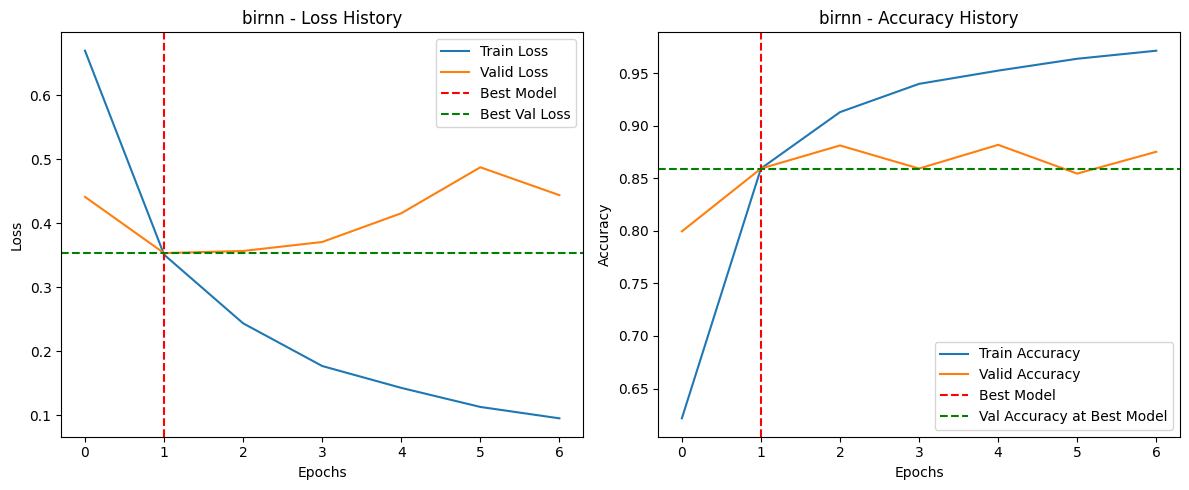

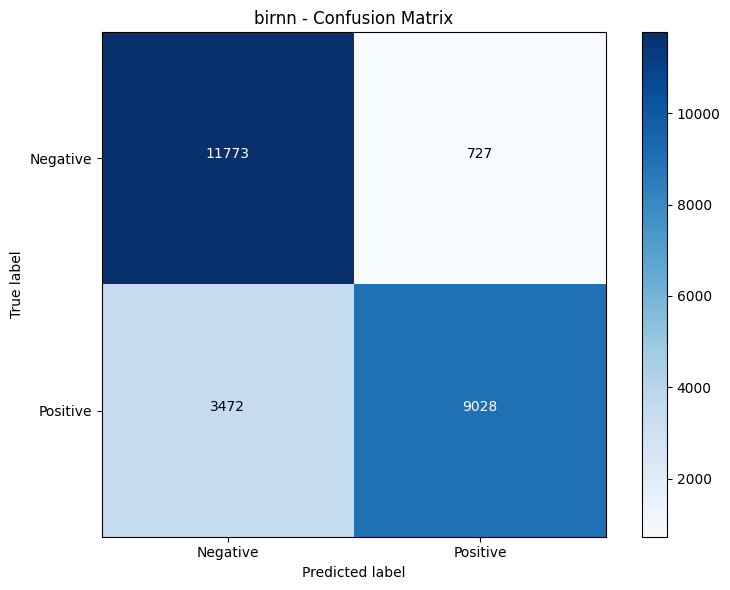

In [10]:
# Plotting hasil pelatihan
plot_training_history(history_birnn.history, "birnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_birnn['y_pred'], "birnn")

### 5. Menyimpan Model

In [11]:
# Menyimpan model
model_birnn.save('model_tensorflow_birnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_birnn.keras'")

Model RNN disimpan sebagai 'model_tensorflow_birnn.keras'


## B. Model Deep RNN Menggunakan TensorFlow

### 1. Menyusun Model Deep RNN


In [12]:
# Fungsi untuk membuat model Deep RNN kompleks dengan LSTM
def build_drnn_model(embedding_dim=128, lstm_units=64, dropout_rate=0.2, recurrent_dropout=0.2, dense_units=64, learning_rate=0.001):
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, embedding_dim),
        
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=False, dropout=dropout_rate),
        BatchNormalization(),
        
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 4, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Menyusun model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# inisialisasi model
model_drnn = build_drnn_model()

### 2. Melatih Model

In [13]:
# Melatih model RNN awal
print("Melatih model RNN...")
history_drnn = train_model_tf(model_drnn, (X_train_pad, y_train), 'drnn')

# Fungsi untuk membuat model dengan hyperparameter tuning
def build_hptune_drnn_model(hp):
    # Hyperparameters to tune
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=32)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    recurrent_dropout = hp.Float('recurrent_dropout', min_value=0.0, max_value=0.3, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    
    model = build_drnn_model(
        embedding_dim=embedding_dim,
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        recurrent_dropout=recurrent_dropout,
        dense_units=dense_units,
        learning_rate=learning_rate
    )
    
    return model

# Inisialisasi hyperparameter tuner
tuner_drnn = kt.Hyperband(
    build_hptune_drnn_model,
    objective='val_accuracy',
    max_epochs=8,
    factor=3,
    directory='tuning_results',
    project_name='tuning_drnn'
)

# Menjalankan hyperparameter tuning
tuner_drnn.search(X_train_pad, y_train, epochs=4, batch_size=BATCH_SIZE, validation_split=0.2,
             shuffle=True,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
             verbose=1
)

# Menampilkan hasil hyperparameter tuning
best_hps_drnn = tuner_drnn.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters:")
print(f"Embedding dimension: {best_hps_drnn.get('embedding_dim')}")
print(f"LSTM units: {best_hps_drnn.get('lstm_units')}")
print(f"Dropout rate: {best_hps_drnn.get('dropout_rate')}")
print(f"Recurrent dropout rate: {best_hps_drnn.get('recurrent_dropout')}")
print(f"Learning rate: {best_hps_drnn.get('learning_rate')}")
print(f"Dense units: {best_hps_drnn.get('dense_units')}")

# Membangun model dengan hyperparameter terbaik
model_drnn = tuner_drnn.hypermodel.build(best_hps_drnn)

# Melatih model dengan hyperparameter terbaik
print("Melatih model dengan hyperparameter terbaik...")
history_drnn = train_model_tf(model_drnn, (X_train_pad, y_train), 'drnn')

Trial 10 Complete [00h 14m 35s]
val_accuracy: 0.6269999742507935

Best val_accuracy So Far: 0.6269999742507935
Total elapsed time: 01h 57m 22s
Best Hyperparameters:
Embedding dimension: 96
LSTM units: 32
Dropout rate: 0.2
Recurrent dropout rate: 0.2
Learning rate: 0.0012756860315943877
Dense units: 128
Melatih model dengan hyperparameter terbaik...
Memulai pelatihan model drnn...
Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 100ms/step - accuracy: 0.5011 - loss: 0.6989 - val_accuracy: 0.4960 - val_loss: 0.6935
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 104ms/step - accuracy: 0.5026 - loss: 0.6939 - val_accuracy: 0.5020 - val_loss: 0.6932
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 128s 103ms/step - accuracy: 0.5112 - loss: 0.6931 - val_accuracy: 0.5018 - val_loss: 0.6931
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.5048 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6933
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 128s 102ms/step - accuracy: 0.4997 - lo

### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [14]:
# Evaluasi model RNN
result_drnn = evaluate_model_tf(model_drnn, test_data, 'drnn')

782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step

Evaluasi Model drnn:
Accuracy: 0.8520
Precision: 0.8463
Recall: 0.8604
F1 Score: 0.8533
AUC: 0.9227


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

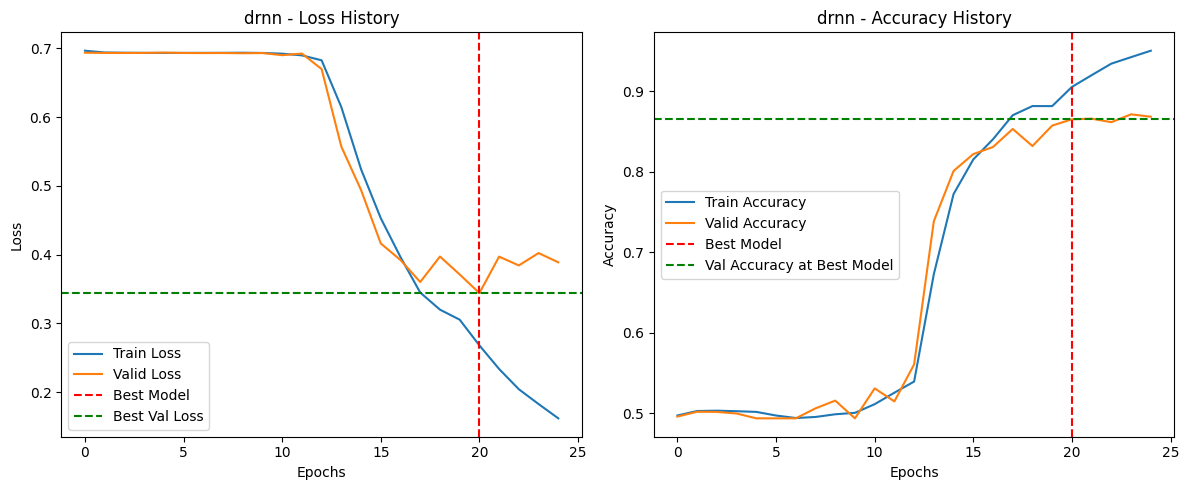

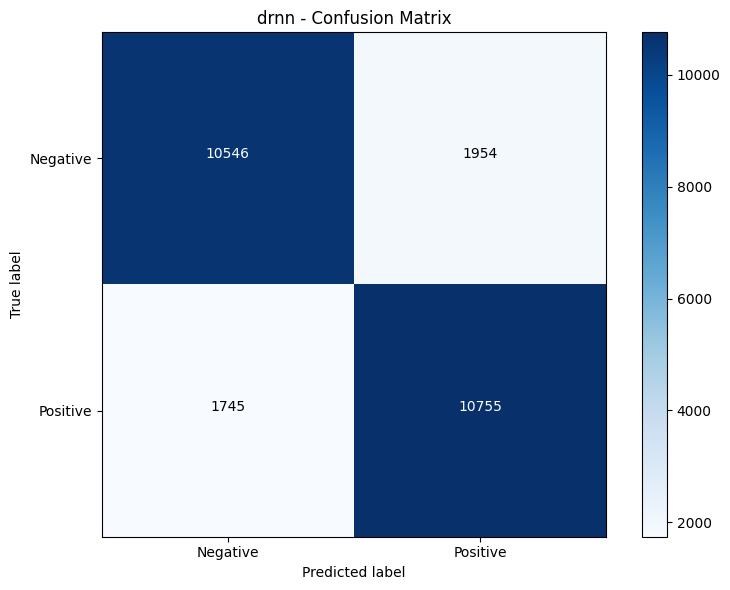

In [15]:
# Plotting hasil pelatihan
plot_training_history(history_drnn.history, "drnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_drnn['y_pred'], "drnn")

### 5. Menyimpan Model

In [16]:
# Menyimpan model
model_drnn.save('model_tensorflow_drnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_drnn.keras'")

Model RNN disimpan sebagai 'model_tensorflow_drnn.keras'


# Perbandingan antara model

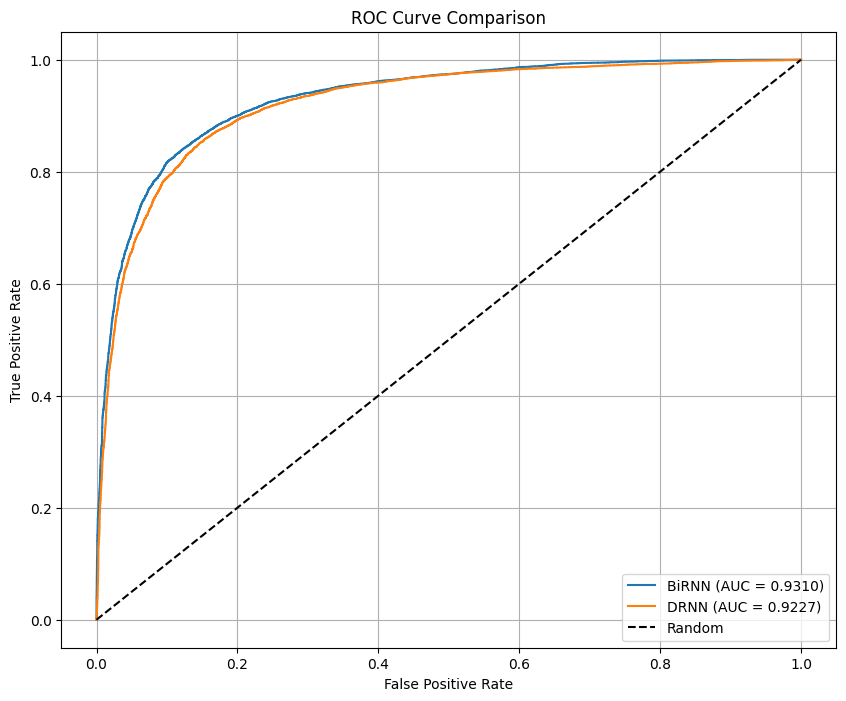

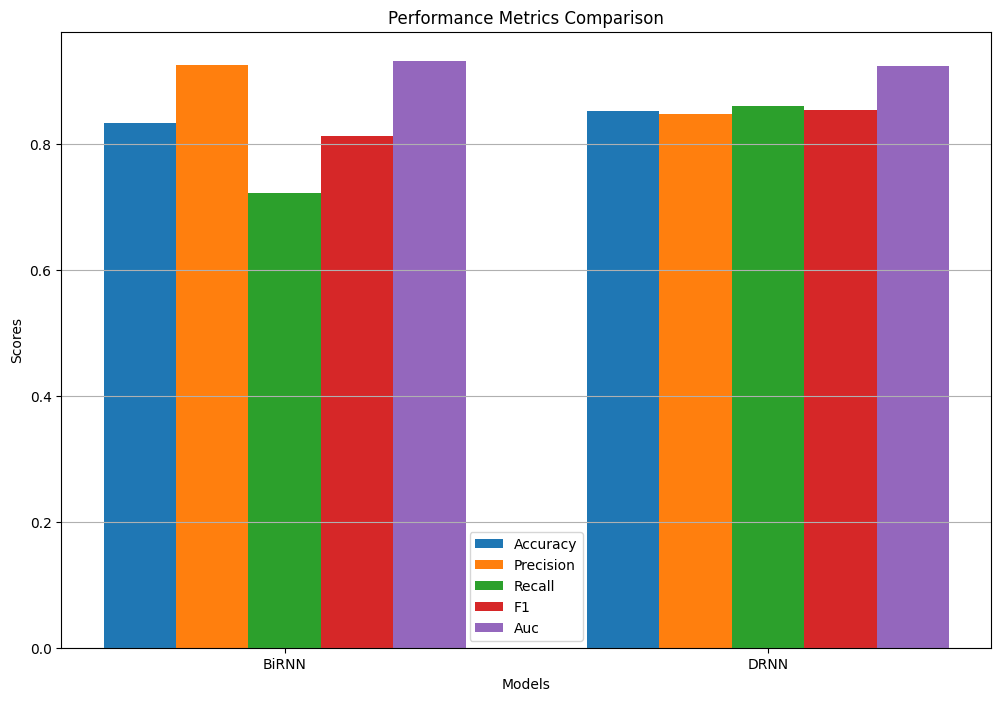

In [17]:
# Menghitung perbandingan untuk semua model
results_dict = {
    'BiRNN': result_birnn,
    'DRNN': result_drnn,
}

# Plotting ROC curve
plot_roc_curve(results_dict)
# Plotting perbandingan metrik
plot_metrics_comparison(results_dict)